# Multi-layer Perceptron Classifier for df_merged_mean_15x15_final

# Table of Contents<a class="anchor" id="Contents"></a>
* [Load Packages](#Packages)
* [Load Dataset](#Dataset)
    * [Train Test Validation Split](#Train_Test_Validation_Split)
* [Functions](#Functions)
* [Multi-layer Perceptron Classifier](#MLP)
    * [Run the Model](#Run_MLP)
    * [ROC Curve and Precision-Recall Curve](#Curve_MLP)
    * [Results](#Results_MLP)
* [Multi-layer Perceptron Classifier with PCA](#PCA)
* [Test data for different regions](#Regions)
    

# Load Packages<a class="anchor" id="Packages"></a>

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.metrics import RocCurveDisplay, auc, roc_auc_score, make_scorer, f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, accuracy_score, confusion_matrix, classification_report, roc_curve
from sklearn.metrics import silhouette_score
from keras.optimizers import Adam
import random
import csv
import statistics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.utils.class_weight import compute_class_weight
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [20]:
from joblib import load

best_mlp = load('best_model/best_mlp_mean.joblib')
best_mlp_pc = load('best_model/best_mlp_mean_pc.joblib')

* [Table of Contents](#Contents)

# Load Dataset<a class="anchor" id="Dataset"></a>

In [3]:
df_merged_mean_15x15 = pd.read_csv('data/df_merged_mean_15x15_final.csv')
df_merged_mean_15x15

,time,site,BBP_1x1_median,CDM_1x1_median,SPM_1x1_median,KD490_1x1_median,ZSD_1x1_median,CHL_1x1_median,BBP_1x1_mean,CDM_1x1_mean,...,KD490_15x15_q1,ZSD_15x15_q1,CHL_15x15_q1,BBP_15x15_q3,CDM_15x15_q3,SPM_15x15_q3,KD490_15x15_q3,ZSD_15x15_q3,CHL_15x15_q3,riskLevelLabel
0,2020-01-22,ukd4305-43260,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1
1,2020-02-17,ukk3106-27200,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1
2,2020-02-29,ukk4304-34200,0.0,0.0,0.206118,0.173157,0.127656,0.066746,0.0,0.0,...,0.185487,0.127656,0.073864,0.0,0.0,0.206118,0.177503,0.127656,0.069289,1
3,2020-03-01,ukk4305-25400,0.0,0.0,0.097241,0.098771,0.247233,0.026437,0.0,0.0,...,0.105168,0.243885,0.028865,0.0,0.0,0.097241,0.101709,0.247233,0.027571,1
4,2020-03-12,uke1200-08100,0.0,0.0,0.163267,0.201963,0.107813,0.085368,0.0,0.0,...,0.216346,0.107813,0.094473,0.0,0.0,0.163267,0.207033,0.107813,0.088622,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187106,2022-11-08,ukj3400-17700,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0
187107,2022-12-02,ukk3103-29500,0.0,0.0,0.029326,0.058402,0.482674,0.010515,0.0,0.0,...,0.062560,0.482674,0.011637,0.0,0.0,0.029326,0.059867,0.482674,0.010916,1
187108,2022-12-07,ukk3103-29100,0.0,0.0,0.022588,0.178036,0.150990,0.075031,0.0,0.0,...,0.156235,0.137526,0.055946,0.0,0.0,0.018829,0.182504,0.155471,0.077890,1
187109,2022-12-08,ukk3103-29100,0.0,0.0,0.017684,0.076698,0.330753,0.016954,0.0,0.0,...,0.081440,0.329495,0.018444,0.0,0.0,0.016590,0.078670,0.333127,0.017600,0


In [4]:
counts_normalized = df_merged_mean_15x15['riskLevelLabel'].value_counts(normalize=True)
counts_normalized

0    0.971797
1    0.028203
Name: riskLevelLabel, dtype: float64

## Train Test Validation Split<a class="anchor" id="Train_Test_Validation_Split"></a>

In [5]:
train_labels_mean_zero = pd.read_csv('data/train_labels_mean_zero.csv')[['time', 'site']]
train_labels_mean_zero

,time,site
0,2021-05-25,ukk4305-25800
1,2022-07-04,ukk4305-25800
2,2022-08-08,ukk3105-31450
3,2022-08-27,ukk2206-20800
4,2020-06-08,uke1301-09020
...,...,...
112261,2021-07-19,ukj4210-12660
112262,2021-05-10,ukk4200-23200
112263,2020-08-10,ukk3104-33500
112264,2021-09-08,ukk1202-35700


In [6]:
validation_labels_mean_zero = pd.read_csv('data/validation_labels_mean_zero.csv')[['time', 'site']]
validation_labels_mean_zero

,time,site
0,2020-07-02,ukj3400-17400
1,2022-08-27,ukk3106-32200
2,2021-05-06,ukk4307-33900
3,2021-05-20,ukk4304-34100
4,2021-06-04,ukk3104-33200
...,...,...
37417,2021-07-28,ukk3103-29800
37418,2021-05-02,uke2206-07200
37419,2022-09-08,ukk4301-21800
37420,2021-07-18,ukj2403-15900


In [7]:
test_labels_mean_zero = pd.read_csv('data/test_labels_mean_zero.csv')[['time', 'site']]
test_labels_mean_zero

,time,site
0,2022-09-21,ukk3106-32100
1,2020-08-08,ukh1407-10750
2,2020-09-20,ukd4200-42100
3,2022-07-06,ukk2206-20900
4,2021-08-24,ukk4305-26100
...,...,...
37418,2021-09-22,ukj2402-15680
37419,2021-08-14,ukk3104-33500
37420,2022-05-20,ukk4305-25600
37421,2022-06-25,ukj3400-18000


In [8]:
# Train test validation split
df_train = df_merged_mean_15x15.merge(train_labels_mean_zero, on=['time', 'site'], how='inner')
df_val = df_merged_mean_15x15.merge(validation_labels_mean_zero, on=['time', 'site'], how='inner')
df_test = df_merged_mean_15x15.merge(test_labels_mean_zero, on=['time', 'site'], how='inner')

df_train.drop(['time', 'site'], axis=1, inplace=True)
df_val.drop(['time', 'site'], axis=1, inplace=True)
df_test.drop(['time', 'site'], axis=1, inplace=True)

y_train = df_train.pop('riskLevelLabel')
y_val = df_val.pop('riskLevelLabel')
y_test = df_test.pop('riskLevelLabel')

X_train = df_train
X_val = df_val
X_test = df_test

print('Training X Shape:', X_train.shape)
print('Training y Shape:', y_train.shape)
print('Validation X Shape:', X_val.shape)
print('Validation y Shape:', y_val.shape)
print('Testing X Shape:', X_test.shape)
print('Testing y Shape:', y_test.shape)

Training X Shape: (112266, 192)
Training y Shape: (112266,)
Validation X Shape: (37422, 192)
Validation y Shape: (37422,)
Testing X Shape: (37423, 192)
Testing y Shape: (37423,)


* [Table of Contents](#Contents)

# Functions<a class="anchor" id="Functions"></a>

In [32]:
def pr_curve(model, X_test, y_test):
    y_pred = model.predict(X_test)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    prc_auc = auc(recall, precision)
    fig, ax = plt.subplots()
    ax.plot(recall, precision, label='Precision recall curve (area = %0.2f)' % prc_auc)
    ax.axhline(y=counts_normalized[1], color='gray', linestyle='--', label='baseline')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall Curve')
    ax.legend(loc="lower right")
    plt.show()
    return fig

In [33]:
def draw_roc(model, X_test, y_test):
    y_pred = model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Curve')
    ax.legend(loc="lower right")
    plt.show()
    return fig

In [49]:
def test_evaluation(model,X_test,y_test):
    y_pred = model.predict(X_test)
    print(str(model),"\nOn test data, Accuracy: %.2f" % accuracy_score(y_test, y_pred))
    print("On test data, Precision: %.2f" %precision_score(y_test, y_pred))
    print("On test data, Recall: %.2f" %recall_score(y_test, y_pred))
    print("On test data, f1 score: %.2f "%f1_score(y_test, y_pred))
    cm = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    cm.plot
    plt.savefig('results/CM_mean_15x15_mlp_PCA.png')

In [22]:
def save_result(model,X_test,y_test):
    y_pred = model.predict(X_test)
    ACC = accuracy_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    AUC_ROC = auc(fpr, tpr)
    PRE = precision_score(y_test, y_pred)
    REC = recall_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    AUC_PRC = auc(recall, precision)
    F1 = f1_score(y_test, y_pred)
    return ACC, AUC_ROC, PRE, REC, AUC_PRC, F1

* [Table of Contents](#Contents)

# Multi-layer Perceptron Classifier<a class="anchor" id="MLP"></a>

## Hyperparameter tuning function

In [ ]:
def mlp_model(X_train, y_train, X_val, y_val):
    # Apply Random Oversampling
    ros = RandomOverSampler()
    X_train_oversampled, y_train_oversampled = ros.fit_resample(X_train, y_train)

#     params = {'hidden_layer_sizes': [(200,400,200,100), (300,600,300,150), (300, 600, 300), (400,800,400,200)],
#               'activation': ['logistic', 'relu'],
#               'alpha': [0.00001, 0.0001, 0.001]
#              }
    params = {'hidden_layer_sizes': [(200,400,200), (400,800,400,200)],
              'activation': ['logistic', 'relu'],
              'learning_rate': ['adaptive'],
              'alpha': [0.0001, 0.001, 0.01],
              'solver': ['adam', 'sgd']
             }


    best_f1 = 0
    best_params = {}
    for hidden_layer_sizes in params['hidden_layer_sizes']:
        for activation in params['activation']:
            for learning_rate in params['learning_rate']:
                for alpha in params['alpha']:
                    for solver in params['solver']:
                        mlp_model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                                                 activation=activation,
                                                 learning_rate=learning_rate,
                                                 alpha=alpha,
                                                 solver=solver,
                                                 batch_size=1000,
                                                 random_state=100,
                                                 max_iter=500)
                        temp_model = mlp_model.fit(X_train_oversampled, y_train_oversampled)
                        y_val_pred = mlp_model.predict(X_val)
                        f1 = f1_score(y_val, y_val_pred)

                        if f1 > best_f1:
                            best_f1 = f1
                            best_params = {'hidden_layer_sizes': hidden_layer_sizes, 'activation': activation,
                                           'learning_rate': learning_rate, 'alpha': alpha, 'solver': solver}
                            best_mlp = temp_model

    print('Best Hyperparameters:', best_params)
    return best_mlp

## Run the Model<a class="anchor" id="Run_MLP"></a>

### Select the best hyperparameter on validation data

In [24]:
best_mlp = mlp_model(X_train, y_train, X_val, y_val)

Best Hyperparameters: {'hidden_layer_sizes': (400, 800, 400, 200), 'activation': 'relu', 'learning_rate': 'adaptive', 'alpha': 0.0001, 'solver': 'adam'}


## ROC Curve and Precision-Recall Curve<a class="anchor" id="Curve_MLP"></a>

### ROC Curve

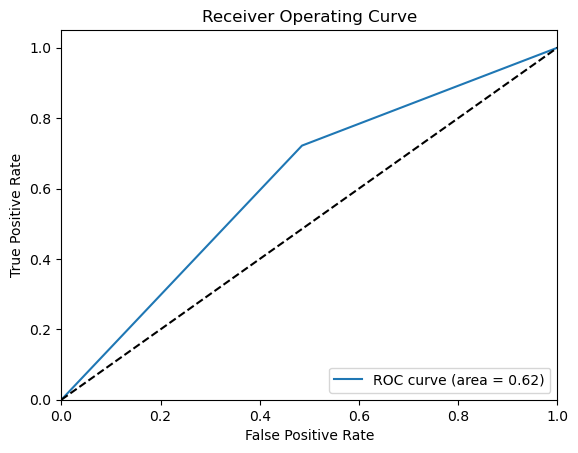

In [36]:
roc_mlp = draw_roc(best_mlp, X_test, y_test)

In [37]:
roc_mlp.savefig('results/ROC_mean_15x15_mlp.png')

### Precision-Recall Curve

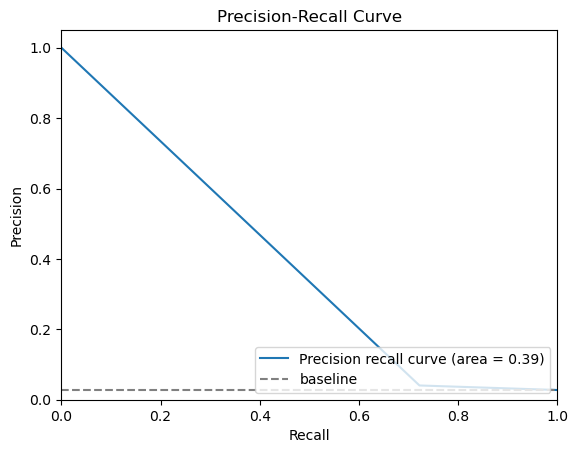

In [38]:
prc_mlp = pr_curve(best_mlp, X_test, y_test)

In [39]:
prc_mlp.savefig('results/PRC_mean_15x15_mlp.png')

## Results<a class="anchor" id="Results_MLP"></a>

MLPClassifier(batch_size=1000, hidden_layer_sizes=(400, 800, 400, 200),
              learning_rate='adaptive', max_iter=1000, random_state=100,
              solver='sgd') 
On test data, Accuracy: 0.52
On test data, Precision: 0.04
On test data, Recall: 0.72
On test data, f1 score: 0.08 


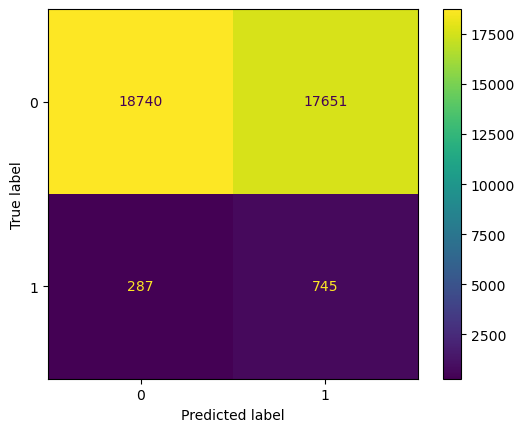

In [40]:
test_evaluation(best_mlp, X_test, y_test)

In [41]:
results_df_mlp = pd.DataFrame([['Multi-layer Perceptron Classifier', 'df_merged_mean_15x15', *save_result(best_mlp,X_test,y_test)]],
                             columns=['Model', 'Sub-Model', 'Accuracy', 'AUC_ROC','Precision','Recall', 'AUC_PRC', 'f1 score'])
results_df_mlp

,Model,Sub-Model,Accuracy,AUC_ROC,Precision,Recall,AUC_PRC,f1 score
0,Multi-layer Perceptron Classifier,df_merged_mean_15x15,0.520669,0.618431,0.040498,0.721899,0.385033,0.076693


In [42]:
results_df_mlp.to_csv('results/results_mean_15x15_mlp.csv')

* [Table of Contents](#Contents)

# Multi-layer Perceptron Classifier with PCA<a class="anchor" id="PCA"></a>

In [32]:
## Fit X_train, X_val, X_test with the PCA
pca = PCA(n_components = 5, random_state = 100)
pca.fit(X_train)
X_train_pc = pca.transform(X_train)
X_val_pc = pca.transform(X_val)
X_test_pc = pca.transform(X_test)
print('the shape of X_train after PCA:',X_train_pc.shape,'the shape of y train:',y_train.shape)
print('the shape of X_val after PCA:',X_val_pc.shape,'the shape of y train:',y_val.shape)
print('the shape of X_test after PCA:',X_test_pc.shape,'the shape of y test:',y_test.shape)

the shape of X_train after PCA: (112266, 5) the shape of y train: (112266,)
the shape of X_val after PCA: (37422, 5) the shape of y train: (37422,)
the shape of X_test after PCA: (37423, 5) the shape of y test: (37423,)


In [44]:
best_mlp_pc = mlp_model(X_train_pc, y_train，X_val_pc, y_val)

Best Hyperparameters: {'hidden_layer_sizes': (400, 800, 400, 200), 'activation': 'relu', 'learning_rate': 'adaptive', 'alpha': 0.0001, 'solver': 'adam'}


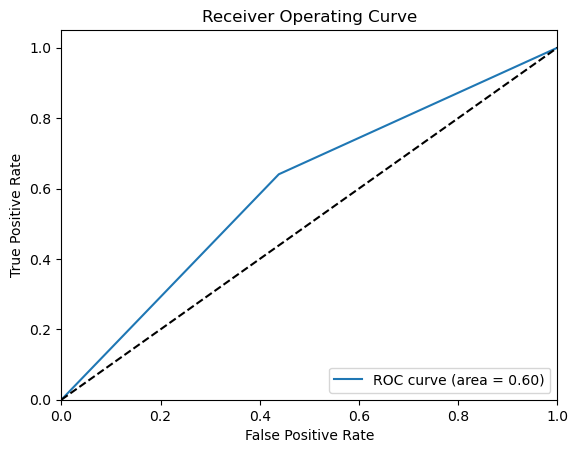

In [45]:
roc_mlp = draw_roc(best_mlp_pc, X_test_pc, y_test)

In [46]:
roc_mlp.savefig('results/ROC_mean_15x15_mlp_PCA.png')

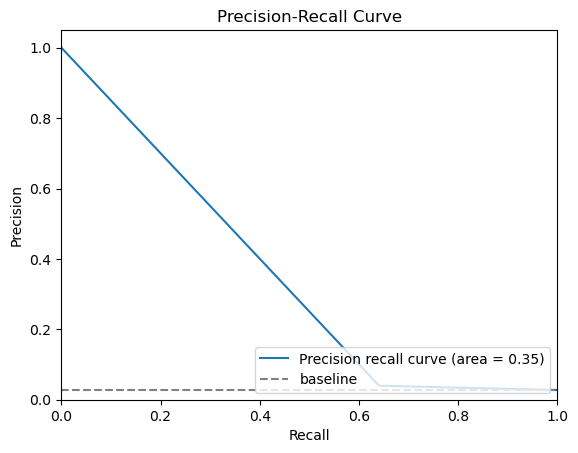

In [47]:
prc_mlp = pr_curve(best_mlp_pc, X_test_pc, y_test)

In [48]:
prc_mlp.savefig('results/PRC_mean_15x15_mlp_PCA.png')

MLPClassifier(batch_size=1000, hidden_layer_sizes=(400, 800, 400, 200),
              learning_rate='adaptive', max_iter=1000, random_state=100) 
On test data, Accuracy: 0.56
On test data, Precision: 0.04
On test data, Recall: 0.64
On test data, f1 score: 0.07 


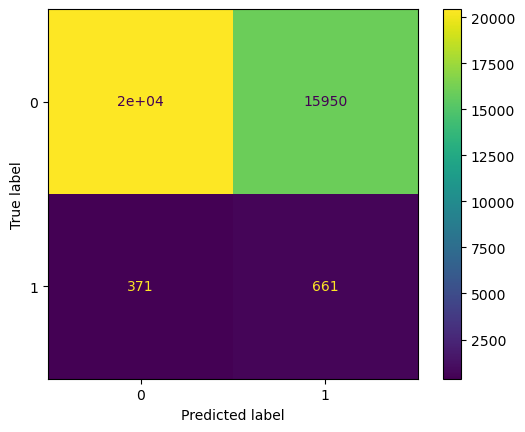

In [50]:
test_evaluation(best_mlp_pc, X_test_pc, y_test)

In [51]:
results_df_mlp = pd.DataFrame([['Multi-layer Perceptron Classifier', 'df_merged_mean_15x15', *save_result(best_mlp_pc,X_test_pc,y_test)]],
                             columns=['Model', 'Sub-Model', 'Accuracy', 'AUC_ROC','Precision','Recall', 'AUC_PRC', 'f1 score'])
results_df_mlp

,Model,Sub-Model,Accuracy,AUC_ROC,Precision,Recall,AUC_PRC,f1 score
0,Multi-layer Perceptron Classifier,df_merged_mean_15x15,0.563878,0.601104,0.039793,0.640504,0.345105,0.074931


In [52]:
results_df_mlp.to_csv('results/results_mean_15x15_mlp_PCA.csv')

* [Table of Contents](#Contents)

# Test data for different regions<a class="anchor" id="Regions"></a>

In [18]:
df_test_region = pd.read_csv('data/df_test_with_region.csv')
df_test_region

,time,site,BBP_1x1_median,CDM_1x1_median,SPM_1x1_median,KD490_1x1_median,ZSD_1x1_median,CHL_1x1_median,BBP_1x1_mean,CDM_1x1_mean,...,ZSD_15x15_q1,CHL_15x15_q1,BBP_15x15_q3,CDM_15x15_q3,SPM_15x15_q3,KD490_15x15_q3,ZSD_15x15_q3,CHL_15x15_q3,riskLevelLabel,region
0,2020-03-15,ukd1103-45920,0.000000,0.000000,0.224705,0.139928,0.163001,0.047225,0.000000,0.000000,...,0.163001,0.052261,0.000000,0.000000,0.224705,0.143440,0.163001,0.049024,1,North West
1,2020-05-14,ukc1202-06400,0.173845,0.334632,0.050227,0.547162,0.056594,0.404667,0.173845,0.334632,...,0.055334,0.447822,0.173845,0.334632,0.052587,0.595561,0.056594,0.456223,0,North East
2,2020-05-14,ukc1404-05700,0.000000,0.000000,0.054811,0.292889,0.091505,0.163252,0.000000,0.000000,...,0.091505,0.169985,0.000000,0.000000,0.055301,0.300240,0.091505,0.169473,0,North East
3,2020-05-14,ukc1404-05800,0.000000,0.000000,0.054811,0.292889,0.091505,0.163252,0.000000,0.000000,...,0.091505,0.169985,0.000000,0.000000,0.055301,0.300240,0.091505,0.169473,0,North East
4,2020-05-14,ukc2101-04000,0.000000,0.000000,0.019815,0.194332,0.115622,0.081084,0.000000,0.000000,...,0.115622,0.089731,0.000000,0.000000,0.019815,0.199209,0.115622,0.084173,0,North East
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37418,2022-09-30,ukk4305-25400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,South West
37419,2022-09-30,ukk4305-26300,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,South West
37420,2022-09-30,ukk4306-23000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,South West
37421,2022-10-13,ukd4200-42300,0.553052,0.173062,0.347609,0.233709,0.092781,0.107562,0.553052,0.173062,...,0.094669,0.111871,0.553052,0.173062,0.347609,0.238232,0.096504,0.111281,0,North West


In [39]:
df_test_sw = df_test_region[df_test_region['region']=='South West']
df_test_sw = df_test_sw.drop(columns=['region', 'time', 'site'], axis=1)
y_test_sw = df_test_sw.pop('riskLevelLabel')
X_test_sw = df_test_sw
# X_test_sw_pc = pca.transform(X_test_sw)

In [47]:
df_test_se = df_test_region[df_test_region['region']=='South East']
df_test_se = df_test_se.drop(columns=['region', 'time', 'site'], axis=1)
y_test_se = df_test_se.pop('riskLevelLabel')
X_test_se = df_test_se

In [41]:
df_test_ee = df_test_region[df_test_region['region']=='East of England']
df_test_ee = df_test_ee.drop(columns=['region', 'time', 'site'], axis=1)
y_test_ee = df_test_ee.pop('riskLevelLabel')
X_test_ee = df_test_ee

In [42]:
df_test_ne = df_test_region[df_test_region['region']=='North East']
df_test_ne = df_test_ne.drop(columns=['region', 'time', 'site'], axis=1)
y_test_ne = df_test_ne.pop('riskLevelLabel')
X_test_ne = df_test_ne

In [43]:
df_test_nw = df_test_region[df_test_region['region']=='North West']
df_test_nw = df_test_nw.drop(columns=['region', 'time', 'site'], axis=1)
y_test_nw = df_test_nw.pop('riskLevelLabel')
X_test_nw = df_test_nw

In [44]:
df_test_yh = df_test_region[df_test_region['region']=='Yorkshire and The Humber']
df_test_yh = df_test_yh.drop(columns=['region', 'time', 'site'], axis=1)
y_test_yh = df_test_yh.pop('riskLevelLabel')
X_test_yh = df_test_yh

In [45]:
df_test_em = df_test_region[df_test_region['region']=='East Midlands']
df_test_em = df_test_em.drop(columns=['region', 'time', 'site'], axis=1)
y_test_em = df_test_em.pop('riskLevelLabel')
X_test_em = df_test_em

In [52]:
results_df_mlp_regions = pd.DataFrame([['Multi-layer Perceptron Classifier', 'df_merged_mean_15x15', 'South West', *save_result(best_mlp,X_test_sw,y_test_sw)],
                                  ['','', 'South East', *save_result(best_mlp,X_test_se,y_test_se)], 
                                 ['','', 'East of England', *save_result(best_mlp,X_test_ee,y_test_ee)], 
                                 ['','', 'North East', *save_result(best_mlp,X_test_ne,y_test_ne)], 
                                 ['','', 'North West', *save_result(best_mlp,X_test_nw,y_test_nw)], 
                                 ['','', 'Yorkshire and The Humber', *save_result(best_mlp,X_test_yh,y_test_yh)],
                                 ['','', 'East Midlands', *save_result(best_mlp,X_test_em,y_test_em)]],
                             columns=['Model', 'Sub-Model', 'Region', 'Accuracy', 'AUC_ROC','Precision','Recall', 'AUC_PRC', 'f1 score'])
results_df_mlp_regions

,Model,Sub-Model,Region,Accuracy,AUC_ROC,Precision,Recall,AUC_PRC,f1 score
0,Multi-layer Perceptron Classifier,df_merged_mean_15x15,South West,0.566049,0.636718,0.039543,0.711061,0.378872,0.074920
1,,,South East,0.532816,0.611961,0.037751,0.695431,0.370537,0.071615
2,,,East of England,0.445014,0.604064,0.025214,0.769231,0.399359,0.048828
3,,,North East,0.526922,0.661174,0.050929,0.804348,0.430686,0.095793
4,,,North West,0.417677,0.573963,0.063063,0.748092,0.412030,0.116320
5,,,Yorkshire and The Humber,0.465066,0.536712,0.043173,0.614286,0.336098,0.080675
6,,,East Midlands,0.337644,0.513462,0.029851,0.700000,0.369236,0.057260


In [53]:
results_df_mlp_regions.to_csv('results/15_mean_MLP/Regions_results.csv', index=False)

* [Table of Contents](#Contents)